In [ ]:
!pip install vizdoom
!cd github/ & git clone https://github.com/mwydmuch/ViZdoom

In [27]:
from vizdoom import *
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.evaluation import evaluate_policy

# Random Agent

In [60]:
game = DoomGame()
game.load_config("github/ViZdoom/scenarios/basic.cfg")
game.init()

In [61]:
episodes = 10
actions = np.eye(3,dtype=np.uint8)

for episode in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        state = game.get_state()
        img = state.screen_buffer
        random_action = random.choice(actions)
        reward = game.make_action(random_action)
        time.sleep(0.02)
    print("Result :", game.get_total_reward())
    time.sleep(2)


Result : -385.0
Result : -380.0
Result : 27.0
Result : 93.0


KeyboardInterrupt: 

# Wrapping Doom Game into a Gym Environment

In [28]:
from gym import Env
from gym.spaces import Discrete, Box
import cv2

In [29]:
class VizDoomGym(Env):
    def __init__(self,render=False):
        super().__init__()
        self.game = DoomGame()
        self.game.load_config("github/ViZdoom/scenarios/basic.cfg")
        
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        self.game.init()
        self.observation_space = Box(low=0, high=255, shape=(85,160,1), dtype=np.uint8) 

        self.action_space = Discrete(3)
        
    def step(self,action):
        actions = np.eye(3, dtype=np.uint8)
        reward = self.game.make_action(actions[action],4)
        
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            info = self.game.get_state().game_variables[0]
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0
            
        info = {"info":info}
        done = self.game.is_episode_finished()
        return state, reward, done, info
    
    def render(self):
        pass
    
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        state = self.grayscale(state)
        return state
    
    def grayscale(self,observation):
        """Grayscale, trim the bottom infos and reduce the number of pixels"""
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        state = state[:85, :]
        return state
    
    def close(self):
        self.game.close()

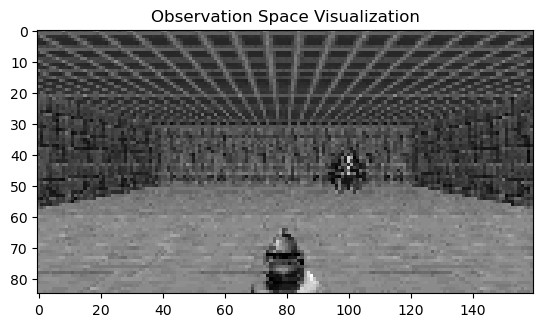

In [708]:
env = VizDoomGym(render=True)
state = env.reset()
plt.imshow(state,cmap="gray")
plt.title("Observation Space Visualization")
plt.show()
env.close()

# Train the model

In [30]:
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

In [716]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [717]:
CHECKPOINT_DIR = './train/train_basic'
LOG_DIR = './logs/log_basic'

In [718]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [719]:
env = VizDoomGym()

In [720]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=2048)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [721]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_basic\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 27       |
|    ep_rew_mean     | -47.2    |
| time/              |          |
|    fps             | 52       |
|    iterations      | 1        |
|    time_elapsed    | 38       |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 28.7       |
|    ep_rew_mean          | -59.6      |
| time/                   |            |
|    fps                  | 56         |
|    iterations           | 2          |
|    time_elapsed         | 72         |
|    total_timesteps      | 4096       |
| train/                  |            |
|    approx_kl            | 0.00858381 |
|    clip_fraction        | 0.122      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.09      |
|    explained_variance   | 7.21e-06   |
|    learni

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 9.1         |
|    ep_rew_mean          | 61.5        |
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 11          |
|    time_elapsed         | 432         |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.049893063 |
|    clip_fraction        | 0.357       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.875      |
|    explained_variance   | 0.588       |
|    learning_rate        | 0.0001      |
|    loss                 | 828         |
|    n_updates            | 100         |
|    policy_gradient_loss | 0.00238     |
|    value_loss           | 2.18e+03    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 6.54  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 5.45        |
|    ep_rew_mean          | 79.7        |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 21          |
|    time_elapsed         | 829         |
|    total_timesteps      | 43008       |
| train/                  |             |
|    approx_kl            | 0.050794013 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.359      |
|    explained_variance   | 0.794       |
|    learning_rate        | 0.0001      |
|    loss                 | 264         |
|    n_updates            | 200         |
|    policy_gradient_loss | 0.00537     |
|    value_loss           | 226         |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.16  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.68        |
|    ep_rew_mean          | 82.8        |
| time/                   |             |
|    fps                  | 52          |
|    iterations           | 31          |
|    time_elapsed         | 1216        |
|    total_timesteps      | 63488       |
| train/                  |             |
|    approx_kl            | 0.008917961 |
|    clip_fraction        | 0.0749      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.134      |
|    explained_variance   | 0.69        |
|    learning_rate        | 0.0001      |
|    loss                 | 44.6        |
|    n_updates            | 300         |
|    policy_gradient_loss | 0.0119      |
|    value_loss           | 54.4        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 4.52  

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.62        |
|    ep_rew_mean          | 88.4        |
| time/                   |             |
|    fps                  | 51          |
|    iterations           | 41          |
|    time_elapsed         | 1638        |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.022186395 |
|    clip_fraction        | 0.0515      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.0778     |
|    explained_variance   | 0.68        |
|    learning_rate        | 0.0001      |
|    loss                 | 33          |
|    n_updates            | 400         |
|    policy_gradient_loss | 0.00836     |
|    value_loss           | 57.2        |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.75  

# Test the model

In [31]:
model = PPO.load('./train/train_basic/best_model_100000.zip')

In [34]:
env = VizDoomGym(render=False)

In [730]:
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=100)
"Mean reward : " + str(mean_reward)

'Mean reward : 86.24'

In [35]:
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    frames = []
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        frame = env.render()
        frames.append(frame)
        time.sleep(0.30)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode,total_reward))
    time.sleep(0.5)
env.close()

Total Reward for episode 0 is 87.0
Total Reward for episode 1 is 75.0
Total Reward for episode 2 is 95.0
Total Reward for episode 3 is 95.0
Total Reward for episode 4 is 95.0
Total Reward for episode 5 is 91.0
Total Reward for episode 6 is 95.0
Total Reward for episode 7 is 95.0
Total Reward for episode 8 is 67.0
Total Reward for episode 9 is 95.0
